In [1]:
# run 
# jupyter nbconvert --to script 2d_linear_confidenceintervals.ipynb
# to convert to .py strict and run the .py!
import scipy.stats as ss
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVR  # for building SVR model

import sys
sys.path.insert(0,'..')

from BMR.bmr import *
from pyearth import Earth
import pandas as pd

In [54]:
def gen_model(X, a, b, c, d, e):
    return a*X[:, 0] + b*X[:, 1] + c*X[:, 0]**2 + d*X[:, 1]**2 + e*X[:, 0]*X[:, 1]
def gen_data(n, a, b, c, d, e, eps):
    norm = ss.norm()
    #norm = ss.uniform(loc=-4, scale=8)
    X = norm.rvs(size=(n, 2))
    y = gen_model(X=X, a=a, b=b, c=c, d=d, e=e)
    if eps>0:
        y += ss.norm(loc=0, scale=eps).rvs(size=(n, ))
    y = y[:, np.newaxis]
    return X, y

def get_mars_params(x, y):
    param_grid = {"max_terms": [1, 2, 3, 5, 10], "max_degree": [1, 2, 3, 4, 5]}
    mars = Earth()
    sh = HalvingGridSearchCV(mars, param_grid, cv=3, factor=3, n_jobs=2).fit(x, y)
    return sh.best_params_

def get_svr_params(x, y):
    param_grid = {"C": [0.1, 1, 10, 100, 300, 500, 750, 1000, 1500, 2000, 3000], "degree": [1, 2, 3, 4],
                  "epsilon": [0.01, 0.1, 1, 10]}
    svr = SVR(kernel="rbf")
    sh = HalvingGridSearchCV(svr, param_grid, cv=5, factor=3, n_jobs=2).fit(x, y)
    return sh.best_params_

def get_bmr_params(x, y, M, degree):
    n_trial = x.shape[0]
    param_grid = {
        "epsilon": [0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0],
        "min_n_pts": [2, 5, 10, 25, 50, 100],
    }
    bmr = BMR(min_n_pts=10, M=M, substitution_policy="nearest", degree=degree, epsilon=0.5)
    sh = HalvingGridSearchCV(bmr, param_grid, cv=3, factor=3, n_jobs=2).fit(x, y)
    params = sh.best_params_
    params['M'] = M
    return params

In [3]:
# generate points in which prediction is made
grid_points = np.arange(-3, 4, 1)
mesh_X, mesh_Y = np.meshgrid(grid_points, grid_points)
mesh_pts = np.array([np.ravel(mesh_X), np.ravel(mesh_Y)]).transpose()

#balls: 121
ball betas
[[-1.96756861  0.02909173]
 [ 0.1547831   0.04293385]
 [ 0.92926578 -0.03992491]
 [-0.32706276 -0.01101447]]
[-1.01223959  0.02101655  1.69542921 -0.04173799]
LR betas
[[ 0.12178639 -0.07517576]]
[4.98884581]
diff
[-3.92696941 -4.9724852  -2.52691825 -4.96642251]


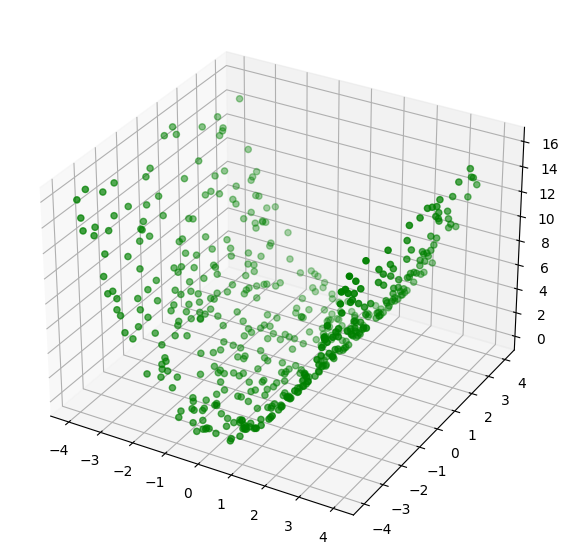

In [32]:
# betas = []
# coefs = []
# xpts = np.array([[-1, 0], [0, 0], [1, 0], [0, 1]])
# for i in range(1):
#     X, y = gen_data(n=500, a=0, b=0, c=1, d=0, e=0, eps=0.01)
#     #plt.plot(X[:, 0], y, 'o')
#     fig = plt.figure(figsize = (10, 7))
#     ax = plt.axes(projection ="3d")
#     ax.scatter3D(X[:, 0], X[:, 1], y, color = "green")
#     bmr = BMR(epsilon=0.5, min_n_pts=3, M=20)
#     bmr.fit(X, y)
#     beta, intercept = bmr.coefficients(xpts)
#     lr = LinearRegression().fit(X, y)
#     coefs.append(lr.coef_)
#     betas.append(beta)
#     print(f'#balls: {len(bmr.ball_mappers[0].vertices_pos)}')
#     print('ball betas')
#     print(beta)
#     print(intercept)
#     print('LR betas')
#     print(lr.coef_)
#     print(lr.intercept_)
#     print('diff')
#     print(bmr.predict(xpts)-lr.predict(xpts)[:, 0])

In [47]:
def run_experiment(n, a, b, c, d, e, eps, mcloops=100):
    alpha = 0.05
    filename = f'_CI_n={n}_a={a}_b={b}_c={c}_d{d}_e{e}_eps={eps}.csv'
    
    X_pred = mesh_pts
    y_true = gen_model(X_pred, a, b, c, d, e)

    #generate one sample to set method parameters
    X, y = gen_data(n=n, a=a, b=b, c=c, d=d, e=e, eps=eps)
    bmr_params = get_bmr_params(X, y, M=20, degree=1)
    #bmr_params = {'epsilon': 1, 'min_n_pts': 5, 'M': 10}
    mars_params = get_mars_params(X, y[:, 0])
    svr_params = get_svr_params(X, y[:, 0])
    
    # init methods
    methods_labels = ['LR', 'BMR', 'MARS', 'SVR']
    
    results = {}
    betas = {}
    intercepts = {}
    for method_label in methods_labels:
        results[method_label] = []
        betas[method_label] = []
        intercepts[method_label] = []

    for loop in range(mcloops):
        if loop % 10 == 0:
            print(f'Running loop {loop}/{mcloops} for {filename}')
        
        # run all methods on new data set
        X, y = gen_data(n=n, a=a, b=b, c=c, d=d, e=e, eps=eps)
        methods = [LinearRegression(), BMR(**bmr_params), Earth(**mars_params), SVR(**svr_params)]
        for method_label, method in zip(methods_labels, methods):
            if method_label == 'SVR':
                method.fit(X, y[:, 0])
            else:
                method.fit(X, y)
            pred = method.predict(X_pred)
            if len(pred.shape) > 1:
                pred = pred[:, 0]
            results[method_label].append(pred)
            # save coefficients
            if method_label == 'BMR':
                beta, intercept = method.coefficients(X_pred)
                betas['BMR'].append(beta)
                intercepts['BMR'].append(intercept)
            if method_label == 'LR':
                betas['LR'].append(method.coef_)
                intercepts['LR'].append(method.intercept_)
    coeff = {}
    coeff['BMR_low_beta1'] = np.quantile(np.array(betas['BMR']), q=alpha/2, axis=0)[:, 0] 
    coeff['BMR_low_beta2'] = np.quantile(np.array(betas['BMR']), q=alpha/2, axis=0)[:, 1] 
    coeff['BMR_up_beta1'] = np.quantile(np.array(betas['BMR']), q=1-alpha/2, axis=0)[:, 0]
    coeff['BMR_up_beta2'] = np.quantile(np.array(betas['BMR']), q=1-alpha/2, axis=0)[:, 1]
    coeff['BMR_low_I'] = np.quantile(np.array(intercepts['BMR']), q=alpha/2, axis=0) 
    coeff['BMR_up_I'] = np.quantile(np.array(intercepts['BMR']), 1-alpha/2, axis=0) 
    coeff['LR_low_beta1'] = np.quantile(np.array(betas['LR']), q=alpha/2, axis=0)[:, 0].tolist()*X_pred.shape[0]
    coeff['LR_low_beta2'] = np.quantile(np.array(betas['LR']), q=alpha/2, axis=0)[:, 1].tolist()*X_pred.shape[0]
    coeff['LR_up_beta1'] = np.quantile(np.array(betas['LR']), q=1-alpha/2, axis=0)[:, 0].tolist()*X_pred.shape[0]
    coeff['LR_up_beta2'] = np.quantile(np.array(betas['LR']), q=1-alpha/2, axis=0)[:, 1].tolist()*X_pred.shape[0]
    coeff['LR_low_I'] = np.quantile(np.array(intercepts['LR']), q=alpha/2, axis=0).tolist()*X_pred.shape[0]
    coeff['LR_up_I'] = np.quantile(np.array(intercepts['LR']), q=1-alpha/2, axis=0).tolist()*X_pred.shape[0]
       
    # collect the results and prepare the csv
    df0 = pd.DataFrame([mesh_pts[:, 0], mesh_pts[:, 1]]).transpose()
    df0.columns = ['x', 'y']
    dfs = [df0]
    for method_label in methods_labels:
        dat = np.array(results[method_label]).transpose()
        ci_low = np.quantile(dat, q=alpha/2, axis=1)
        ci_up = np.quantile(dat, q=1-alpha/2, axis=1)
        mse = np.mean((dat - y_true.reshape(-1,1))**2, axis=1)
        df = pd.DataFrame([ci_low, ci_up, ci_up-ci_low, mse]).transpose()
        df.columns = [f'{method_label}_CI_low', f'{method_label}_CI_up', f'{method_label}_CI_len', f'{method_label}_MSE']
        dfs.append(df)
    # add DataFrame containing coefficients
    dfs.append(pd.DataFrame(coeff))
    df = pd.concat(dfs, axis=1)
    df.to_csv(filename, index=False)
    return df, betas, coeff

In [58]:
#df, betas, coeff = run_experiment(n=500, a=0, b=0, c=1, d=1, e=0, eps=0.0001, mcloops=100)

In [59]:
# # df, betas, coeff = run_experiment(n=500, a=0, b=0, c=1, d=1, e=0, eps=0.0001, mcloops=100)
# # {'epsilon': 5.0, 'min_n_pts': 2, 'M': 20}
# # NORMAL
# df[['x', 'y', 'BMR_low_beta1', 'BMR_up_beta1', 'BMR_low_beta2', 'BMR_up_beta2']]

In [60]:
# # df, betas, coeff = run_experiment(n=500, a=0, b=0, c=1, d=1, e=0, eps=0.0001, mcloops=100)
# # {'epsilon': 5.0, 'min_n_pts': 100, 'M': 20}
# # UNIFORM
# df[['x', 'y', 'BMR_low_beta1', 'BMR_up_beta1', 'BMR_low_beta2', 'BMR_up_beta2']]

In [61]:
# # df, betas, coeff = run_experiment(n=500, a=0, b=0, c=1, d=1, e=0, eps=0.0001, mcloops=100)
# # {'epsilon': 0.24970063583258964, 'min_n_pts': 150, 'M': 20}
# # UNIFORM
# df[['x', 'y', 'BMR_low_beta1', 'BMR_up_beta1', 'BMR_low_beta2', 'BMR_up_beta2']]

In [62]:
# # bmr_params = {'epsilon': 1, 'min_n_pts': 5, 'M': 10}
# # UNIFORM
# df[['x', 'y', 'BMR_low_beta1', 'BMR_up_beta1', 'BMR_low_beta2', 'BMR_up_beta2']]

In [63]:
# pd.DataFrame.from_dict(coeff)

In [106]:
parser = argparse.ArgumentParser()
parser.add_argument("--a", type=float, required=True, help="param a")
parser.add_argument("--b", type=float, required=True, help="param b")
parser.add_argument("--c", type=float, required=True, help="param c")
parser.add_argument("--d", type=float, required=True, help="param d")
parser.add_argument("--e", type=float, required=True, help="param e")
parser.add_argument("--eps", type=float, required=True, help="noise")
parser.add_argument("--M", type=int, required=True, help="number of MC loops")
args = parser.parse_args()

usage: ipykernel_launcher.py [-h] --f F
ipykernel_launcher.py: error: the following arguments are required: --f


SystemExit: 2

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
ns = [100, 1000]

for n in ns:
    run_experiment(n=n, a=args.a, b=args.b, c=args.c, d=args.d, e=args.e, eps=args.eps, mcloops=args.M)

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-p

Running loop 0/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 10/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 20/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 30/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 40/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 50/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 60/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 70/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 80/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 90/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 100/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 110/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 120/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-

/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Running loop 130/1000 for CI_n=100_a=0_b=0_c=0_d0_e0_eps=0.01.csv


/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/home/rafal/LocalRegression/localised-regression/venv/lib/python3.9/site-packages/sklearn_contrib_py_earth-0.1.0-py3.9-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/home/rafal/LocalRegression/localised-